In [68]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Taking user input for the number to be factorized
N = int(input("Enter the bi-prime to factorize: "))

# Number of qubits to be given to the z-register
n_float = np.log2(N)

# n-float is converted to integer to initialize the registers
if int(np.ceil(n_float)) == n_float: 
    n = int(np.ceil(n_float)) + 1 # if N is a power of 2
else:
    n = int(np.ceil(n_float)) # if N is not a power of 2

z_register = [i for i in range(n)]

# The algorithm is very sensitive to the number of qubits in the x and y registers. For n=3, at least 2 qubits per register are required.
if n == 3:
    x_register = [i for i in range(n, n+2)]
    y_register = [i for i in range(n+2,n+4)]
else:
    x_register = [i for i in range(n, 2*n-2)]
    y_register = [i for i in range(2*n-2,3*n-3)]


# Creating the "device" on which all operations will take place
dev = qml.device("default.qubit", wires = x_register + y_register + z_register)
n_wires = len(dev.wires)

# This section defines functions which are used to carry out the "classical" multiplication of qubits, which is done using the quantum fourier transform
def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

def multiplication(x_register, y_register, z_register):
    # Prepare sol-qubits to counting
    qml.QFT(wires=z_register)

    for i in range(len(y_register)):
        for j in range(len(x_register)):
            coeff = 2 ** (len(x_register) + len(y_register) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[y_register[i], x_register[j]])(coeff, z_register)

    # Return to computational basis
    qml.adjoint(qml.QFT)(wires=z_register)



# Defining the number of iterations required for the probabilities of the factors to be amplified
iterations = int(np.ceil((np.pi/4)*(np.sqrt(N))))-1

# User is given a choice to either go with the pre-defined number of iterations or to define the iterations on their own
user_choice = input(f"Current number of iterations = {iterations}. Use User defined iterations? (Warning: Resulting factors may be incorrect due to overamplification) (y/n): ") # Overamplification can suppress the the probabilities of the actual factors

if user_choice == "y":
    iterations = int(input("Enter number of iterations: "))
elif user_choice == "n":
    iterations = iterations
else: 
     raise Exception("Choose either 'y' or 'n'") 

# Here is where we define our factorization circuit
@qml.qnode(dev)
def factorization(N, x_register, y_register, z_register, iterations):
    # Creating a superpostion of states with equal probabilities
    for wire in x_register:
        qml.Hadamard(wires=wire)

    for wire in y_register:
        qml.Hadamard(wires=wire)
    #Finding the factors
    for i in range(iterations):
        
        # Beginning of Oracle
        multiplication(x_register, y_register, z_register) # Apply the multiplication

        qml.FlipSign(N, wires=z_register) # Change sign of N
        
        qml.adjoint(multiplication)(x_register, y_register, z_register) # Uncompute multiplication
        #End of Oracle
        
        # Apply Grover Diffusion operator
        qml.GroverOperator(wires=x_register + y_register)

    return qml.probs(x_register) # Returning probabilities 

Enter the bi-prime to factorize:  35
Current number of iterations = 4. Use User defined iterations? (Warning: Resulting factors may be incorrect due to overamplification) (y/n):  n


In [69]:
# User is given the choice to draw the circuit
draw = input("Draw the circuit? For very large N, the circuit may be too large to be drawn. : (y/n)")

Draw the circuit? For very large N, the circuit may be too large to be drawn. : (y/n) y


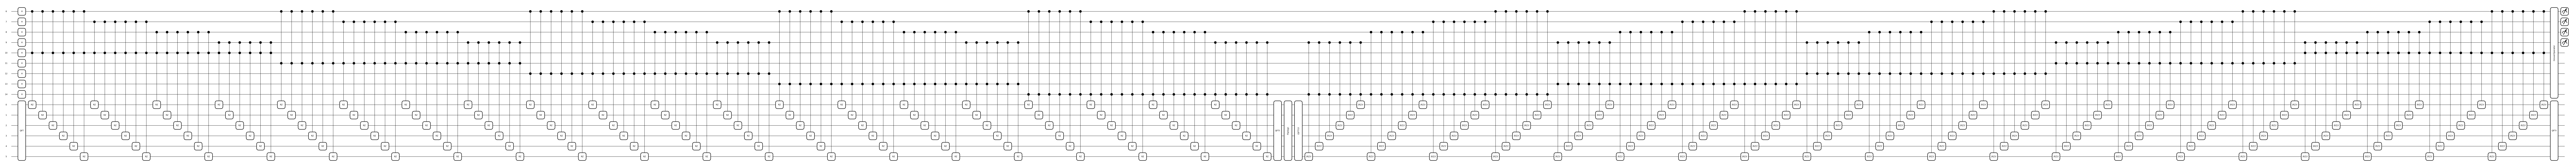

In [70]:
if draw == "y":
    qml.draw_mpl(factorization)(N, x_register, y_register, z_register, 1)
    plt.show()
elif draw != "y" and draw !="n":
    raise Exception("Choose either 'y' or 'n'")


In [71]:
# The np.argmax function returns the position of the element having the largest argument. These positions ARE the factors!
p = np.argmax(factorization(N, x_register, y_register, z_register, iterations))
q = np.argmax(factorization(N, y_register, x_register, z_register, iterations))

# The if-else statement is to account for errors that may occur due to the size of the registers being too large 
if p >= q:
    p = N//q
else:
    q = N//p

# The factors are now printed
print(f"The factors of the {N} are {p} and {q}")

The factors of the 35 are 7 and 5
